**Step 1: GPU configuration**

In [1]:
%%time
# Step 1: GPU configuration
!nvidia-smi

Tue Jan  2 19:15:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Step 2: Mount Google Drive**

In [2]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 3: Install required packages**

In [3]:
!pip install tensorflow_addons
!pip install visualkeras
!pip install -U tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.0 MB/s eta 0:00:00


**Step 4: Import libraries**

In [4]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

import warnings
import pandas as pd
from sklearn.utils import class_weight
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline

**Step 5: Define labels and image size**

In [5]:
labels = ["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]
img_size = 32

**Step 6: Function to get data**

In [6]:
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


**Step 7: Load data**

In [7]:
data_dir = get_data("/content/drive/MyDrive/Luffa Aegyptiaca 480")

**Step 8: Display total number of training images**

In [8]:
image_names = glob.glob(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', '*', '*'))
print("Total number of training images: ", len(image_names))

Total number of training images:  6533


**Step 9: Create a DataFrame with Filename and ClassId**

In [9]:
data_df = pd.DataFrame()
data_df['Filename'] = [img_name.split("/")[-1] for img_name in image_names]
data_df['ClassId'] = [img_name.split("/")[-2] for img_name in image_names]


**Step 10: Display sample images**

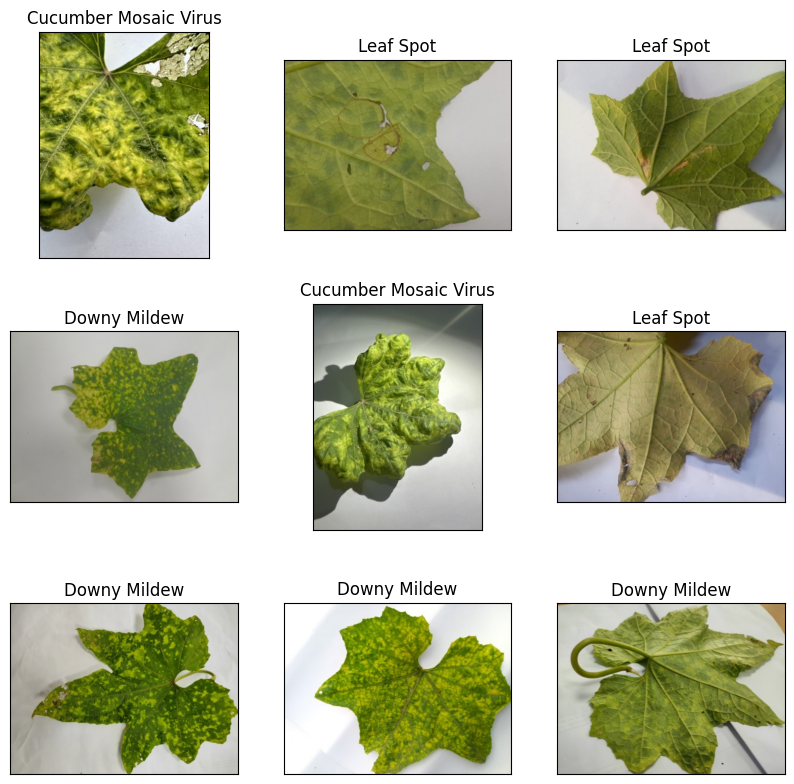

In [10]:
plot_df = data_df.sample(min(9, len(data_df))).reset_index()
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])


**Step 11: Display class distribution**

<BarContainer object of 3 artists>

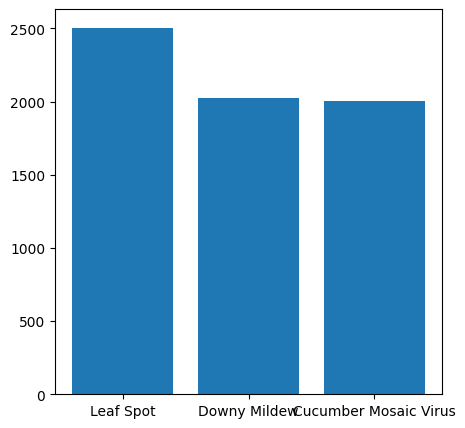

In [11]:
class_id_distribution = data_df['ClassId'].value_counts()
plt.figure(figsize=(5,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)


**Step 12: Preprocess and split data**

In [12]:
X = []
Y = []
for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)


**Step 13: Split data with stratified sampling**

In [13]:
# Make sure to import train_test_split
from sklearn.model_selection import train_test_split

# Split data with stratified sampling
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=8)


**Step 14: Display shapes of train, validation, and test sets**

In [14]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (4820, 32, 32, 3) - y_train shape: (4820,)
x_val shape: (1059, 32, 32, 3) - y_val shape: (1059,)
x_test shape: (654, 32, 32, 3) - y_test shape: (654,)


**Step 16: Set up model parameters**

In [15]:
num_classes = 3
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 250


**Step 17: Data augmentation**

In [16]:
# Make sure to import layers
from keras import layers

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(img_size, img_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


**Step 18: Define CNN model**

In [17]:
def create_cnn_classifier():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPool2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPool2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


**Step 19: Display CNN model summary**

In [18]:
cnn_classifier = create_cnn_classifier()
cnn_classifier.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

**Step 20: Compile CNN model**

In [19]:
initial_learning_rate = learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=weight_decay, staircase=True
)

cnn_classifier.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**Step 21: Run CNN experiment**

In [20]:
# Define early stopping callback
early_stopping_cnn = tf.keras.callbacks.EarlyStopping(
    patience=15,
    verbose=1,
    mode='auto'
)


In [21]:
# Step x: Define CNN

def run_cnn_experiment(model, early_stopping):
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping]
    )
    return history

**Step 22: Create and run CNN model**

In [22]:
# Run CNN experiment
cnn_history = run_cnn_experiment(cnn_classifier, early_stopping_cnn)
test_loss, test_accuracy = cnn_classifier.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/250
38/38 [==============================] - 6s 30ms/step - loss: 0.8745 - accuracy: 0.5871 - val_loss: 0.5696 - val_accuracy: 0.7941
Epoch 2/250
38/38 [==============================] - 0s 9ms/step - loss: 0.4992 - accuracy: 0.8058 - val_loss: 0.4303 - val_accuracy: 0.8404
Epoch 3/250
38/38 [==============================] - 0s 10ms/step - loss: 0.3596 - accuracy: 0.8556 - val_loss: 0.3082 - val_accuracy: 0.8763
Epoch 4/250
38/38 [==============================] - 0s 9ms/step - loss: 0.2619 - accuracy: 0.8950 - val_loss: 0.2540 - val_accuracy: 0.9027
Epoch 5/250
38/38 [==============================] - 0s 8ms/step - loss: 0.1879 - accuracy: 0.9320 - val_loss: 0.1683 - val_accuracy: 0.9415
Epoch 6/250
38/38 [==============================] - 0s 8ms/step - loss: 0.1353 - accuracy: 0.9556 - val_loss: 0.1399 - val_accuracy: 0.9528
Epoch 7/250
38/38 [==============================] - 0s 9ms/step - loss: 0.1269 - accuracy: 0.9577 - val_loss: 0.1008 - val_accuracy: 0.9660
Epoch 8/250

**Step 23: Plot training and validation metrics**

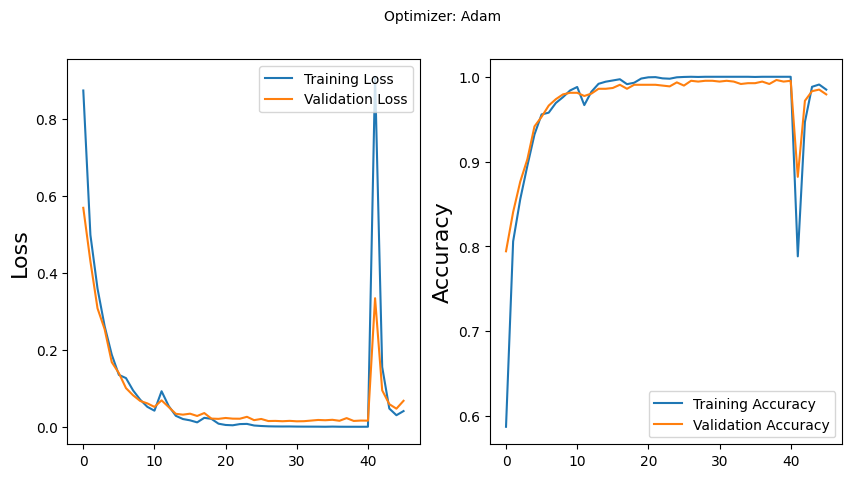

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


**Step 24: Evaluate CNN model on validation set**

In [24]:
cnn_predictions = cnn_classifier.predict(x_val)
cnn_y_pred = [np.argmax(probas) for probas in cnn_predictions]


34/34 [==============================] - 0s 7ms/step


In [25]:
def plot_confusion_matrix_support(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    The values displayed are the actual support values.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]:.0f}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > np.max(cm) / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


**Step 25: Plot normalized confusion matrix for validation set**

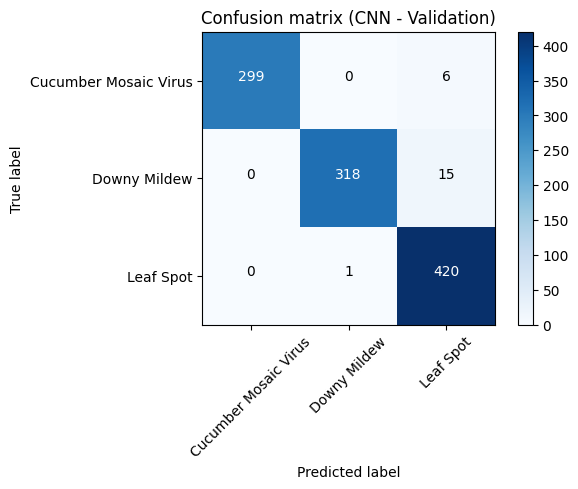

Confusion Matrix:
[[299   0   6]
 [  0 318  15]
 [  0   1 420]]


In [26]:
# Step 25: Plot normalized confusion matrix for validation set

# Compute confusion matrix for validation set
cnf_matrix_cnn = confusion_matrix(y_val, cnn_y_pred)


# Plot confusion matrix for validation set based on support
plt.figure()
plot_confusion_matrix_support(cnf_matrix_cnn, classes=labels, title='Confusion matrix (CNN - Validation)')
plt.show()

# Print the confusion matrix to verify the values
print("Confusion Matrix:")
print(cnf_matrix_cnn)

**Step 26: Display classification report for validation set**

In [27]:
print(classification_report(y_val, cnn_y_pred, target_names=labels))


                       precision    recall  f1-score   support

Cucumber Mosaic Virus       1.00      0.98      0.99       305
         Downy Mildew       1.00      0.95      0.98       333
            Leaf Spot       0.95      1.00      0.97       421

             accuracy                           0.98      1059
            macro avg       0.98      0.98      0.98      1059
         weighted avg       0.98      0.98      0.98      1059



**Step 27: Evaluate CNN model on test set**

In [28]:
cnn_predictions_test = cnn_classifier.predict(x_test)
cnn_y_pred_test = [np.argmax(probas) for probas in cnn_predictions_test]


21/21 [==============================] - 0s 3ms/step


**Step 28: Plot normalized confusion matrix for test set**

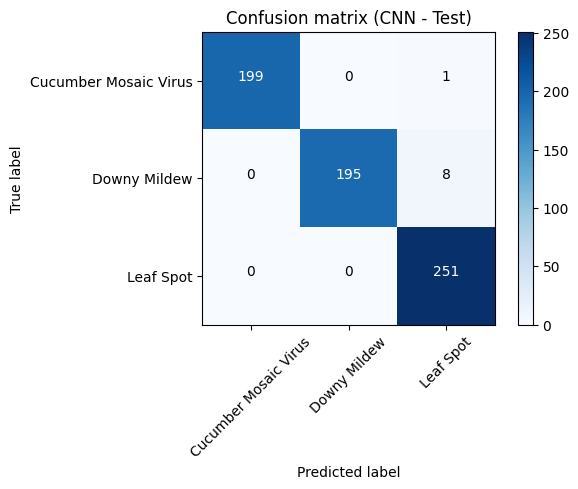

Confusion Matrix (Test):
[[199   0   1]
 [  0 195   8]
 [  0   0 251]]


In [29]:
# Compute confusion matrix for test set
cnf_matrix_cnn_test = confusion_matrix(y_test, cnn_y_pred_test)

# Print the confusion matrix to verify the values


# Plot confusion matrix for test set based on support
plt.figure()
plot_confusion_matrix_support(cnf_matrix_cnn_test, classes=labels, title='Confusion matrix (CNN - Test)')
plt.show()
print("Confusion Matrix (Test):")
print(cnf_matrix_cnn_test)

**Step 29: Display classification report for test set**

In [30]:
print(classification_report(y_test, cnn_y_pred_test, target_names=labels))


                       precision    recall  f1-score   support

Cucumber Mosaic Virus       1.00      0.99      1.00       200
         Downy Mildew       1.00      0.96      0.98       203
            Leaf Spot       0.97      1.00      0.98       251

             accuracy                           0.99       654
            macro avg       0.99      0.99      0.99       654
         weighted avg       0.99      0.99      0.99       654



1/1 [==============================] - 0s 420ms/step


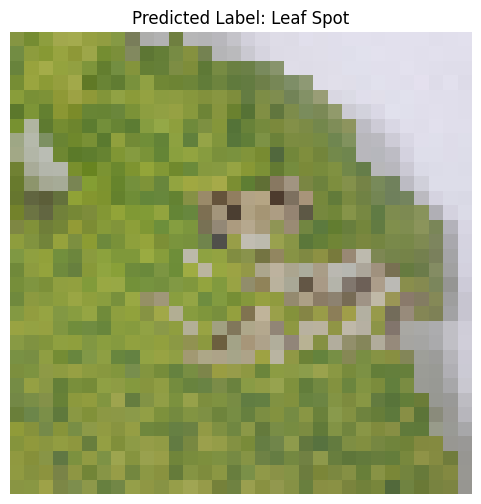

In [32]:
# Replace the path below with the actual path to your new image in Google Drive
new_image_path = '/content/drive/MyDrive/Predicting Image/Leaf-Spot (47).jpg'

# Load and preprocess the new image
new_image = cv2.imread(new_image_path)[...,::-1]  # Convert BGR to RGB format
resized_image = cv2.resize(new_image, (img_size, img_size))
input_image = np.expand_dims(resized_image, axis=0) / 255.0  # Normalize

# Use the trained model to make predictions
predictions = cnn_classifier.predict(input_image)
predicted_label = labels[np.argmax(predictions)]

# Display the original image along with the predicted label
plt.figure(figsize=(6, 6))
plt.imshow(resized_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis("off")
plt.show()